In [1]:
%matplotlib inline
from matplotlib import  pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = '../data_unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path,train=True,download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path,train=False,download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

In [9]:
label_map = {0:0,2:1}#重新定义一个字典用于映射标签，标签类别映射0->0,2->1
class_names = ['airplane','bird']
cifar2 = [(img,label_map[label])
          for img ,label in cifar10
          if label in[0,2]]
cifar2_val = [(img,label_map[label])
              for img,label in cifar10 if label in[0,2]]
type(label_map[2]),type(cifar2),type(cifar2[0])

(int, list, tuple)

In [12]:
cifar2[0][0].shape, 3*32*32

(torch.Size([3, 32, 32]), 3072)

In [11]:
import torch.nn as nn
n_out = 2

In [13]:
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,n_out)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
)

In [14]:
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

In [16]:
x = torch.Tensor([1,2,3])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [20]:
softmax = nn.Softmax(dim=1)#维度即是位置的对应，这里dim 对应数据进行softmax的方向
x = torch.tensor([[1.0,2.0,3.0],
                  [3.0,2.0,-3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.7297, 0.2685, 0.0018]])

In [21]:
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


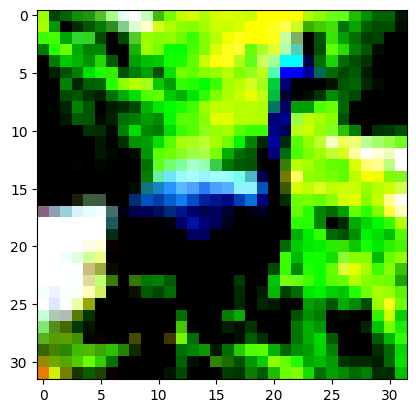

In [22]:
img,_ = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [23]:
img.view(-1).shape

torch.Size([3072])

In [24]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [25]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [26]:
_, index = torch.max(out,dim=1)
index

tensor([1])

In [28]:
out = torch.tensor([
    [0.6,0.4],
    [0.9,0.1],
    [0.3,0.7],
    [0.2,0.8],
])
_,index = torch.max(out,dim=1)
index

tensor([0, 0, 1, 1])

In [30]:
class_index = torch.tensor([0,0,1,1]).unsqueeze(1)
truth = torch.zeros((4,2))
truth.scatter_(dim=1,index=class_index,value= 1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [31]:
def mse(out): #损失函数，均方误差
    return ((out-truth)**2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [32]:
class_index

tensor([[0],
        [0],
        [1],
        [1]])

In [33]:
out.gather(dim=1,index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [34]:
def likelihood(out):
    prod =1.0
    for x in out.gather(dim=1,index=class_index):
        prod *= x
    return prod
likelihood(out)


tensor([0.3024])

In [35]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [37]:
softmax =nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0,104.0]])
softmax(x)

tensor([[0., 1.]])

In [38]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [39]:
log_softmax(x)#log_softmax(x) = log(exp(x) / sum(exp(x)))

tensor([[-104.,    0.]])

In [40]:
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

loss=nn.NLLLoss()

In [44]:
img , label = cifar2[0]
print(label)
out = model(img.view(-1).unsqueeze(0))

loss(out,torch.tensor([label])),out,torch.tensor([label])

1


(tensor(0.5077, grad_fn=<NllLossBackward0>),
 tensor([[-0.9211, -0.5077]], grad_fn=<LogSoftmaxBackward0>),
 tensor([1]))

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(nn.Linear(3072,512),
                      nn.Tanh(),
                      nn.Linear(512,2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(),lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img,label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out,torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch:%d, Loss:%f" %(epoch,float(loss)))

Epoch:0, Loss:8.307038
Epoch:1, Loss:5.457431
Epoch:2, Loss:3.882373
Epoch:3, Loss:3.154704
Epoch:4, Loss:11.443868
Epoch:5, Loss:7.831904
Epoch:6, Loss:0.055682
Epoch:7, Loss:7.118860
Epoch:8, Loss:6.412682
Epoch:9, Loss:5.462630
Epoch:10, Loss:6.324239
Epoch:11, Loss:8.132204
Epoch:12, Loss:4.478361
Epoch:13, Loss:0.397974
Epoch:14, Loss:3.924431
Epoch:15, Loss:6.191980
Epoch:16, Loss:4.834426
Epoch:17, Loss:6.948432
Epoch:18, Loss:0.884499
Epoch:19, Loss:10.726386
Epoch:20, Loss:8.787334
Epoch:21, Loss:5.266410
Epoch:22, Loss:7.096104
Epoch:23, Loss:4.407344
Epoch:24, Loss:6.470562
Epoch:25, Loss:10.756291
Epoch:26, Loss:16.045588
Epoch:27, Loss:13.241747
Epoch:28, Loss:8.135650
Epoch:29, Loss:9.221145
Epoch:30, Loss:11.256797
Epoch:31, Loss:13.286485
Epoch:32, Loss:14.590942
Epoch:33, Loss:19.243477
Epoch:34, Loss:7.613646
Epoch:35, Loss:8.939101
Epoch:36, Loss:5.921707
Epoch:37, Loss:7.737715
Epoch:38, Loss:10.683874
Epoch:39, Loss:6.302479
Epoch:40, Loss:15.454903
Epoch:41, Loss:

In [52]:
train_loader = torch.utils.data.DataLoader(cifar2,batch_size = 64,
                                           shuffle=True)#shuffle洗牌
[(imgs,labels) for imgs,labels in train_loader ][88][0].shape

torch.Size([64, 3, 32, 32])

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,
                                           shuffle=True)

model = nn.Sequential(nn.Linear(3072,128),
                      nn.Tanh(),
                      nn.Linear(128,2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(),lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs,labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        loss = loss_fn(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch:%d , Loss:%f"%(epoch,float(loss)))

Epoch:0 , Loss:0.569737
Epoch:1 , Loss:0.615408
Epoch:2 , Loss:0.517263
Epoch:3 , Loss:0.367134
Epoch:4 , Loss:0.536461
Epoch:5 , Loss:0.294362
Epoch:6 , Loss:0.443925
Epoch:7 , Loss:0.250767
Epoch:8 , Loss:0.241023
Epoch:9 , Loss:0.222313
Epoch:10 , Loss:0.625616
Epoch:11 , Loss:0.206013
Epoch:12 , Loss:0.758667
Epoch:13 , Loss:0.296243
Epoch:14 , Loss:0.717432
Epoch:15 , Loss:0.420388
Epoch:16 , Loss:0.232937
Epoch:17 , Loss:0.392445
Epoch:18 , Loss:0.366999
Epoch:19 , Loss:0.217023
Epoch:20 , Loss:0.316028
Epoch:21 , Loss:0.553657
Epoch:22 , Loss:0.403861
Epoch:23 , Loss:0.122966
Epoch:24 , Loss:0.276965
Epoch:25 , Loss:0.041368
Epoch:26 , Loss:0.306298
Epoch:27 , Loss:0.115355
Epoch:28 , Loss:0.162535
Epoch:29 , Loss:0.284800
Epoch:30 , Loss:0.159053
Epoch:31 , Loss:0.198362
Epoch:32 , Loss:0.135546
Epoch:33 , Loss:0.211421
Epoch:34 , Loss:0.175937
Epoch:35 , Loss:0.160757
Epoch:36 , Loss:0.099110
Epoch:37 , Loss:0.102975
Epoch:38 , Loss:0.169478
Epoch:39 , Loss:0.086546
Epoch:40 ,

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)

model = nn.Sequential(nn.Linear(3072,512),
                      nn.Tanh(),
                      nn.Linear(512,2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(),lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs ,labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        loss = loss_fn(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch:%d, Loss:%f' % (epoch,float(loss)))


Epoch:0, Loss:0.398589
Epoch:1, Loss:0.392393
Epoch:2, Loss:0.492525
Epoch:3, Loss:0.576760
Epoch:4, Loss:0.428428
Epoch:5, Loss:0.669988
Epoch:6, Loss:0.631162
Epoch:7, Loss:0.419822
Epoch:8, Loss:0.436374
Epoch:9, Loss:0.381822
Epoch:10, Loss:0.432960
Epoch:11, Loss:0.409321
Epoch:12, Loss:0.355967
Epoch:13, Loss:0.541395
Epoch:14, Loss:0.486435
Epoch:15, Loss:0.357558
Epoch:16, Loss:0.249969
Epoch:17, Loss:0.376047
Epoch:18, Loss:0.384332
Epoch:19, Loss:0.443832
Epoch:20, Loss:0.266257
Epoch:21, Loss:0.207858
Epoch:22, Loss:0.283811
Epoch:23, Loss:0.279019
Epoch:24, Loss:0.171747
Epoch:25, Loss:0.203455
Epoch:26, Loss:0.498445
Epoch:27, Loss:0.208823
Epoch:28, Loss:0.209781
Epoch:29, Loss:0.332901
Epoch:30, Loss:0.282593
Epoch:31, Loss:0.163801
Epoch:32, Loss:0.110166
Epoch:33, Loss:0.113939
Epoch:34, Loss:0.188702
Epoch:35, Loss:0.148601
Epoch:36, Loss:0.262791
Epoch:37, Loss:0.221348
Epoch:38, Loss:0.089581
Epoch:39, Loss:0.288927
Epoch:40, Loss:0.144150
Epoch:41, Loss:0.146345
Ep

In [63]:
correct = 0
total = 0

with torch.no_grad():
    for imgs,labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(outputs,dim=1)#predicted 给出最大值在dim=1的索引，可以用onehot理解
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        print(outputs.shape,labels.shape[0],predicted.shape,labels.shape)

print("accuracy %f" % (correct/total))

torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Size([64]) torch.Size([64])
torch.Size([64, 2]) 64 torch.Si

In [68]:
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size = 64,
                                         shuffle= False)

correct =0
total = 0

with torch.no_grad():
    for imgs ,labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(outputs,dim=1) #返回两个值，最大值_,和最大值所在索引predicted
        total +=labels.shape[0]
        correct += int((predicted == labels).sum())#predicted == labels 会生成一个布尔类型张量
        print(predicted == labels)

print('accuracy: %f'%(correct/total))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True

In [69]:
model = nn.Sequential(nn.Linear(3072,1024),
                      nn.Tanh(),
                      nn.Linear(1024,512),
                      nn.Tanh(),
                      nn.Linear(512,128),
                      nn.Tanh(),
                      nn.Linear(128,2),
                      nn.LogSoftmax(dim=1))

In [70]:
model = nn.Sequential(
    nn.Linear(3072,1024),
    nn.Tanh(),
    nn.Linear(1024,512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2)
)

loss_fn= nn.CrossEntropyLoss()

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,
                                           shuffle=True)

model = nn.Sequential(nn.Linear(3072,1024),
                      nn.Tanh(),
                      nn.Linear(1024,512),
                      nn.Tanh(),
                      nn.Linear(512,128),
                      nn.Tanh(),
                      nn.Linear(128,2))
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(),lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs =100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        loss = loss_fn(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch:%d, Loss:%f"%(epoch,float(loss)))

Epoch:0, Loss:0.411887
Epoch:1, Loss:0.325810
Epoch:2, Loss:0.362620
Epoch:3, Loss:0.211709
Epoch:4, Loss:0.496899
Epoch:5, Loss:0.362984
Epoch:6, Loss:0.440644
Epoch:7, Loss:0.364916
Epoch:8, Loss:0.389654
Epoch:9, Loss:0.462436
Epoch:10, Loss:0.423134
Epoch:11, Loss:0.338419
Epoch:12, Loss:0.277104
Epoch:13, Loss:0.485736
Epoch:14, Loss:0.379049
Epoch:15, Loss:0.339835
Epoch:16, Loss:0.326133
Epoch:17, Loss:0.271183
Epoch:18, Loss:0.403863
Epoch:19, Loss:0.623221
Epoch:20, Loss:0.415906
Epoch:21, Loss:0.359152
Epoch:22, Loss:0.293376
Epoch:23, Loss:0.506292
Epoch:24, Loss:0.325782
Epoch:25, Loss:0.497799
Epoch:26, Loss:0.253135
Epoch:27, Loss:0.116851
Epoch:28, Loss:0.117814
Epoch:29, Loss:0.437100
Epoch:30, Loss:0.102963
Epoch:31, Loss:0.173413
Epoch:32, Loss:0.377210
Epoch:33, Loss:0.081188
Epoch:34, Loss:0.170106
Epoch:35, Loss:0.089178
Epoch:36, Loss:0.228290
Epoch:37, Loss:0.073422
Epoch:38, Loss:0.107127
Epoch:39, Loss:0.110359
Epoch:40, Loss:0.158746
Epoch:41, Loss:0.079348
Ep

In [72]:
train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=False)

correct=0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(outputs,dim=1)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())

print("Accuracy :%f" % (correct/total))

Accuracy :0.998000


In [75]:
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size =64,
                                         shuffle = False)
correct = 0
total = 0

with torch.no_grad():
    for imgs , labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(outputs,dim=1)
        total += labels.shape[0]
        correct += int((predicted ==labels).sum())
        print(type(total),total)

print("accuracy: %f"%(correct/total))

<class 'int'> 64
<class 'int'> 128
<class 'int'> 192
<class 'int'> 256
<class 'int'> 320
<class 'int'> 384
<class 'int'> 448
<class 'int'> 512
<class 'int'> 576
<class 'int'> 640
<class 'int'> 704
<class 'int'> 768
<class 'int'> 832
<class 'int'> 896
<class 'int'> 960
<class 'int'> 1024
<class 'int'> 1088
<class 'int'> 1152
<class 'int'> 1216
<class 'int'> 1280
<class 'int'> 1344
<class 'int'> 1408
<class 'int'> 1472
<class 'int'> 1536
<class 'int'> 1600
<class 'int'> 1664
<class 'int'> 1728
<class 'int'> 1792
<class 'int'> 1856
<class 'int'> 1920
<class 'int'> 1984
<class 'int'> 2048
<class 'int'> 2112
<class 'int'> 2176
<class 'int'> 2240
<class 'int'> 2304
<class 'int'> 2368
<class 'int'> 2432
<class 'int'> 2496
<class 'int'> 2560
<class 'int'> 2624
<class 'int'> 2688
<class 'int'> 2752
<class 'int'> 2816
<class 'int'> 2880
<class 'int'> 2944
<class 'int'> 3008
<class 'int'> 3072
<class 'int'> 3136
<class 'int'> 3200
<class 'int'> 3264
<class 'int'> 3328
<class 'int'> 3392
<class 'i